In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


In [4]:
# Import libraries
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [5]:
train_original_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_train_original2.npy')
train_mask_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_train_mask2.npy')
validation_original_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_validation_original2.npy')
validation_mask_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_validation_mask2.npy')
#test_original_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_test_original9.npy')
#test_mask_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_test_mask9.npy')

In [ ]:
print("Shape of the data:", test_original_2D.shape)
print("Shape of the data:", train_mask_2D.shape)

Shape of the data: (64, 512, 512, 3)
Shape of the data: (2688, 512, 512, 2)


In [ ]:
# Check the images 2D
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(train_original_2D[467,:,:,0], cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(train_mask_2D[467,:,:,0], cmap='gray')
axes[1].set_title('Mask')

plt.show()

In [ ]:
from keras.models import Model
from keras.layers import Input, Activation, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)

    #Contraction path

    c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #model.summary()

    return model


In [16]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [8]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [17]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [18]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [15]:
model = simple_unet_model(IMG_HEIGHT=512,
                          IMG_WIDTH=512,
                          IMG_CHANNELS=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 512, 512, 1)          0         ['input_2[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 512, 512, 16)         160       ['lambda_1[0][0]']            
                                                                                                  
 dropout_9 (Dropout)         (None, 512, 512, 16)         0         ['conv2d_19[0][0]']           
                                                                                            

In [19]:
model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
#print(model.summary())

In [ ]:
from tensorflow.keras.callbacks import Callback

In [ ]:
class SavePredictionsCallback(Callback):
    def __init__(self, validation_data, save_dir):
        super(SavePredictionsCallback, self).__init__()
        self.validation_data = validation_data
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        predicted_masks = self.model.predict(self.validation_data[0])

        for i in range(len(self.validation_data[0])):
            self.save_or_visualize_results(
                self.validation_data[0][i],
                self.validation_data[1][i],
                predicted_masks[i],
                epoch,
                i
            )

    def save_or_visualize_results(self, input_image, true_mask, predicted_mask, epoch, sample_idx):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(input_image, cmap='gray')
        axes[0].set_title('Input Image')

        axes[1].imshow(true_mask, cmap='gray')
        axes[1].set_title('True Mask')

        axes[2].imshow(predicted_mask, cmap='gray')
        axes[2].set_title('Predicted Mask')

        plt.savefig(os.path.join(self.save_dir, f'epoch_{epoch}_sample_{sample_idx}.png'))
        plt.close()

In [ ]:
save_dir = '/content/drive/MyDrive/2DPart/Model_training_prediction/vanilla2D'
os.makedirs(save_dir, exist_ok=True)

save_predictions_callback = SavePredictionsCallback(validation_data=(validation_original_2D[:,:,:,0], validation_mask_2D[:,:,:,0]), save_dir=save_dir)

In [20]:
history = model.fit(train_original_2D[:,:,:,0],
          train_mask_2D[:,:,:,0],
          batch_size = 4,
          epochs = 40,
          verbose = 1,
          validation_data=(validation_original_2D[:,:,:,0], validation_mask_2D[:,:,:,0]))
          #callbacks=[save_predictions_callback])

Epoch 1/40
112/112 [==============================] - 14s 36ms/step - loss: 0.7409 - iou_score: 0.1888 - f1-score: 0.3101 - val_loss: 0.7606 - val_iou_score: 0.4269 - val_f1-score: 0.5965
Epoch 2/40
112/112 [==============================] - 3s 28ms/step - loss: 0.2909 - iou_score: 0.6236 - f1-score: 0.7643 - val_loss: 0.2692 - val_iou_score: 0.6165 - val_f1-score: 0.7617
Epoch 3/40
112/112 [==============================] - 3s 28ms/step - loss: 0.1643 - iou_score: 0.7467 - f1-score: 0.8543 - val_loss: 0.2150 - val_iou_score: 0.6837 - val_f1-score: 0.8114
Epoch 4/40
112/112 [==============================] - 3s 28ms/step - loss: 0.1378 - iou_score: 0.7841 - f1-score: 0.8784 - val_loss: 0.1776 - val_iou_score: 0.7337 - val_f1-score: 0.8457
Epoch 5/40
112/112 [==============================] - 3s 28ms/step - loss: 0.1239 - iou_score: 0.8041 - f1-score: 0.8910 - val_loss: 0.1642 - val_iou_score: 0.7503 - val_f1-score: 0.8567
Epoch 6/40
112/112 [==============================] - 3s 28ms/st

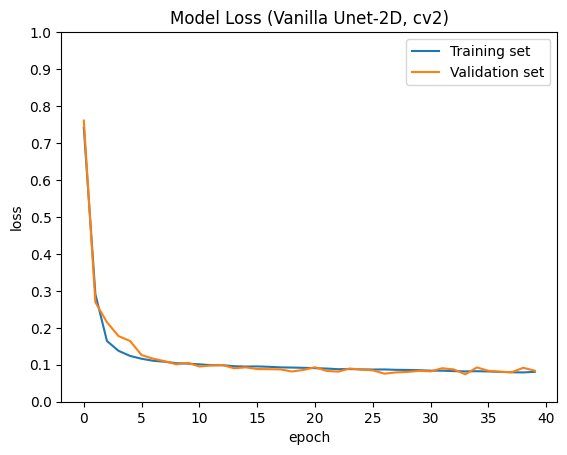

In [21]:
# Plot loss function
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Model Loss (Vanilla Unet-2D, cv2)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')

In [ ]:
model.save('/content/drive/MyDrive/2DPart/2Dmodel/vanilla_2D_aug_cv9.h5')

In [ ]:
# Prediction DICE
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)

    dice = (2.0 * intersection) / (union + 1e-8)
    return dice

In [ ]:
test_original_ori = test_original_2D

In [ ]:
ori_prediction = model.predict(test_original_ori[:,:,:,0])
binary_ori = (ori_prediction > 0.5).astype(int)

In [ ]:
D_ori = dice_coefficient(test_mask_2D[:,:,:,0], binary_ori[:,:,:,0])
print("DICE of using the original structure of Unet 2D:", D_ori)